# Nauðsynlegir pakkar og fylgihlutir

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 706kB 4.0MB/s 


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.4.1


# Sækjum gögnin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
VANGOGH_FILENAMES = tf.io.gfile.glob('/content/drive/MyDrive/VM/Van_Gogh_gogn/tfrec/van_gogh_tfrec/images.tfrecord')
print('VANGOGH tfrec Files:', len(VANGOGH_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob('/content/drive/MyDrive/VM/monet_gogn/tfrec/photo_tfrec/*.tfrec')
print('Photo tfrec Files:', len(PHOTO_FILENAMES))

VANGOGH tfrec Files: 1
Photo tfrec Files: 20


In [ ]:
PHOTO_FILENAMES

['/content/drive/MyDrive/VM/monet_gogn/tfrec/photo_tfrec/photo00-352.tfrec',
 '/content/drive/MyDrive/VM/monet_gogn/tfrec/photo_tfrec/photo01-352.tfrec',
 '/content/drive/MyDrive/VM/monet_gogn/tfrec/photo_tfrec/photo02-352.tfrec',
 '/content/drive/MyDrive/VM/monet_gogn/tfrec/photo_tfrec/photo03-352.tfrec',
 '/content/drive/MyDrive/VM/monet_gogn/tfrec/photo_tfrec/photo04-352.tfrec',
 '/content/drive/MyDrive/VM/monet_gogn/tfrec/photo_tfrec/photo05-352.tfrec',
 '/content/drive/MyDrive/VM/monet_gogn/tfrec/photo_tfrec/photo06-352.tfrec',
 '/content/drive/MyDrive/VM/monet_gogn/tfrec/photo_tfrec/photo07-352.tfrec',
 '/content/drive/MyDrive/VM/monet_gogn/tfrec/photo_tfrec/photo08-352.tfrec',
 '/content/drive/MyDrive/VM/monet_gogn/tfrec/photo_tfrec/photo09-352.tfrec',
 '/content/drive/MyDrive/VM/monet_gogn/tfrec/photo_tfrec/photo10-352.tfrec',
 '/content/drive/MyDrive/VM/monet_gogn/tfrec/photo_tfrec/photo11-352.tfrec',
 '/content/drive/MyDrive/VM/monet_gogn/tfrec/photo_tfrec/photo12-352.tfrec',

Kóði her fyrir neðan af https://www.kaggle.com/jcsantiago/step-by-step-cyclegan-photos-to-monet-paintings

In [ ]:
IMAGE_SIZE = [256, 256]

#Fall sem normalizar myndir á bilið [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image/127.5)-1
    return image

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = normalize(image)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [ ]:
vangogh_ds = load_dataset(VANGOGH_FILENAMES, labeled=True).batch(100)
#photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [ ]:
example_vangogh = next(iter(vangogh_ds))
#example_photo = next(iter(photo_ds))

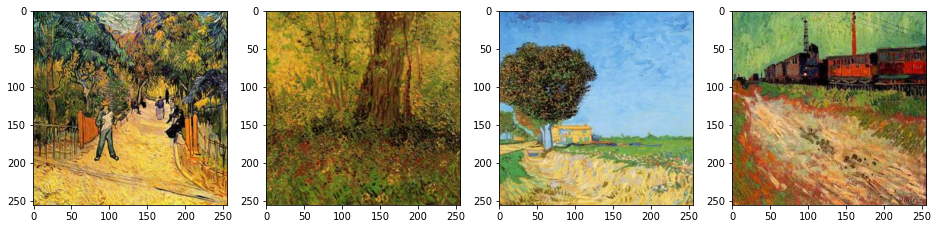

In [ ]:
fig = plt.figure(figsize=(16,4))
plt.subplot(141)
plt.imshow(example_vangogh[43]*0.5+0.5)
plt.subplot(142)
plt.imshow(example_vangogh[73]*0.5+0.5)
plt.subplot(143)
plt.imshow(example_vangogh[93]*0.5+0.5)
plt.subplot(144)
plt.imshow(example_vangogh[88]*0.5+0.5)

# Módel
Samanstendur af:

*   Generator
*   Discriminator
*   Kostnaðarföllum
*   Optimizers



# Generator

Arkítektúrinn byggir á U-Net (https://en.wikipedia.org/wiki/U-Net), sem er földunarnet sem samanstendur af kóðara (downsample) og afkóðara (upsample). UNET: notað upprunalega fyrir svona semantic localization, concatenation einkenna gefur upplýsingar um það


In [ ]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma))

    result.add(layers.LeakyReLU())

    return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [ ]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

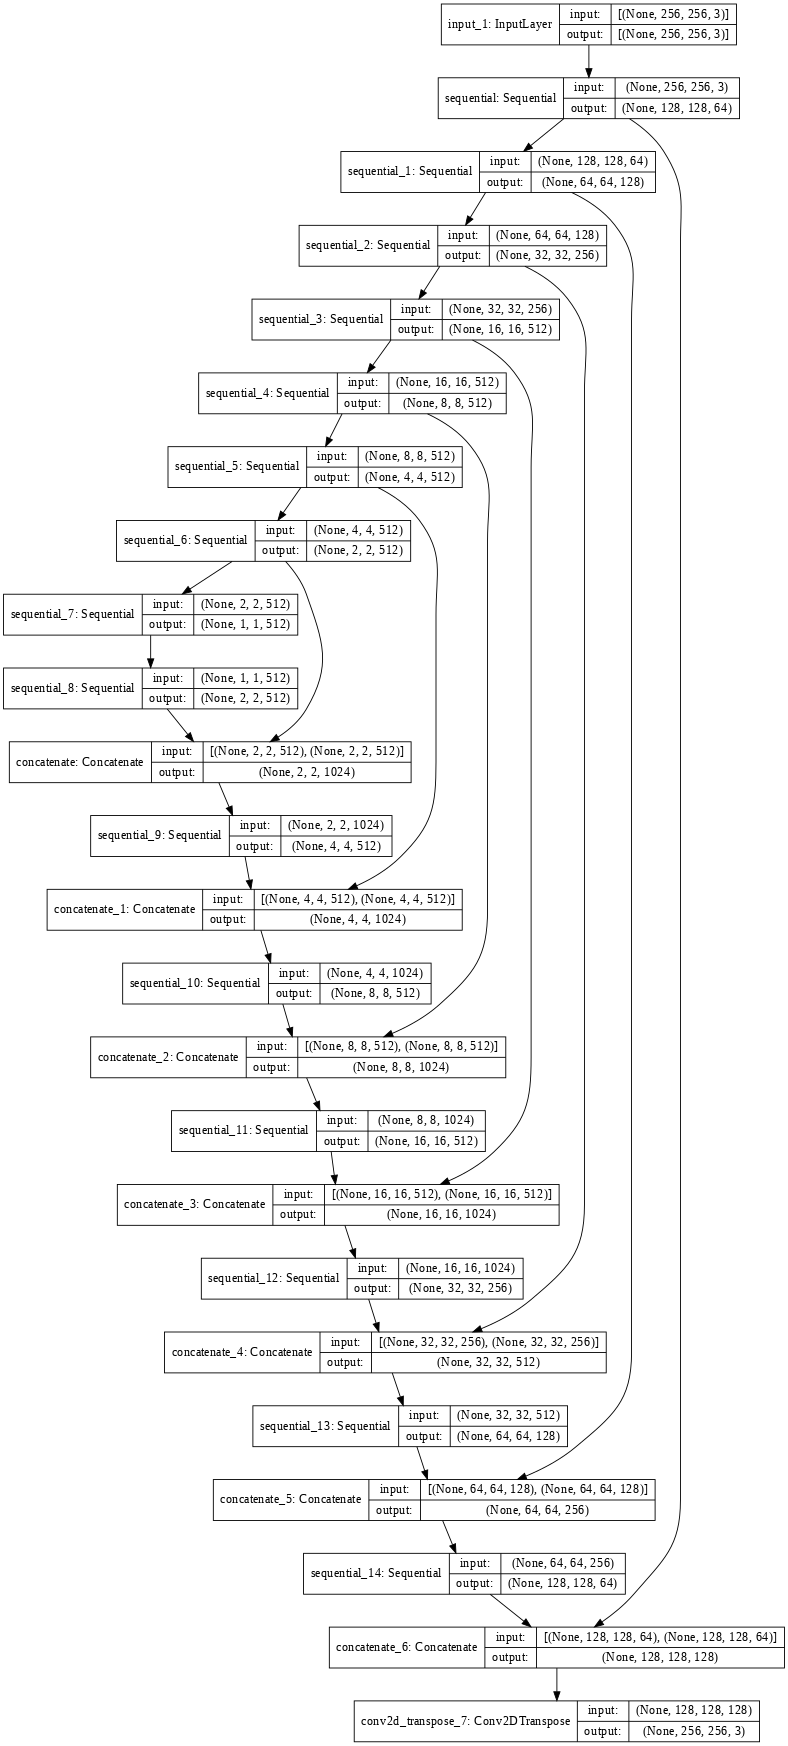

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

# Discriminator

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

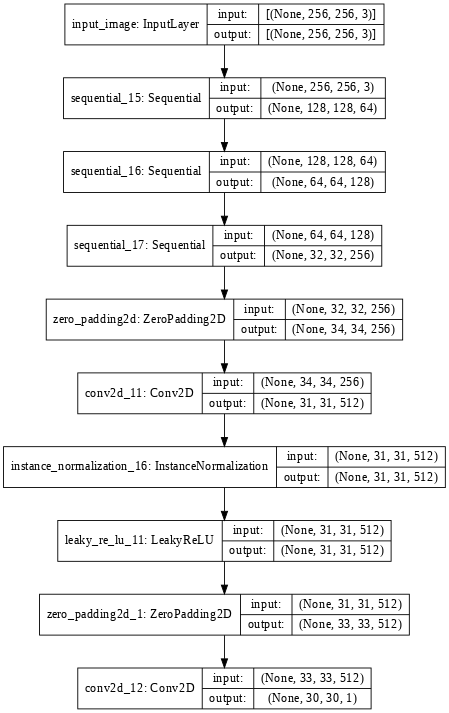

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
with strategy.scope():
  vangogh_generator = Generator() #breytir ljósmyndum í málverk
  photo_generator = Generator() #breytir málverkum í ljósmyndir

  vangogh_discriminator = Discriminator() #flokkar raunveruleg málverk í sundur frá vélrænum málverkum
  photo_discriminator = Discriminator() #flokkar raunverulegar ljósmyndir í sundur frá vélrænum ljósmyndum

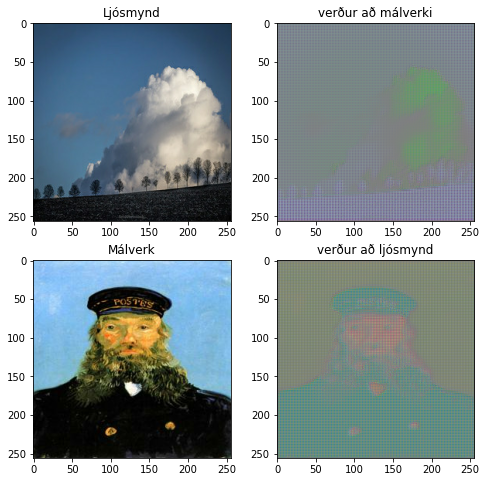

In [ ]:
#Prófum generatorinn: sjá https://www.tensorflow.org/tutorials/generative/cyclegan
to_vangogh = vangogh_generator(example_photo)
to_photo = photo_generator(example_vangogh)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [example_photo, to_vangogh, example_vangogh, to_photo]
title = ['Ljósmynd', 'verður að málverki', 'Málverk', 'verður að ljósmynd']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

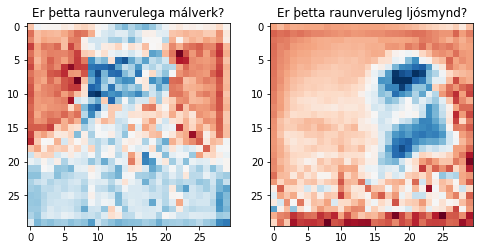

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Er þetta raunverulega málverk?')
plt.imshow(vangogh_discriminator(example_vangogh)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Er þetta raunveruleg ljósmynd?')
plt.imshow(photo_discriminator(example_photo)[0, ..., -1], cmap='RdBu_r')

plt.show()

# Kostnaðarföll

In [ ]:
LAMBDA = 10

In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
      real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

      generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

      total_disc_loss = real_loss + generated_loss

      return total_disc_loss * 0.5

with strategy.scope():
    def generator_loss(generated):
      return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
      loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

      return LAMBDA * loss1

with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
      loss = tf.reduce_mean(tf.abs(real_image - same_image))
      return LAMBDA * 0.5 * loss

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        vangogh_generator,
        photo_generator,
        vangogh_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.v_gen = vangogh_generator
        self.p_gen = photo_generator
        self.v_disc = vangogh_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        v_gen_optimizer,
        p_gen_optimizer,
        v_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.v_gen_optimizer = v_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.v_disc_optimizer = v_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_vangogh, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to vangogh back to photo
            fake_vangogh = self.v_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_vangogh, training=True)

            # vangogh to photo back to vangogh
            fake_photo = self.p_gen(real_vangogh, training=True)
            cycled_vangogh = self.v_gen(fake_photo, training=True)

            # generating itself
            same_vangogh = self.v_gen(real_vangogh, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_vangogh = self.v_disc(real_vangogh, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_vangogh = self.v_disc(fake_vangogh, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            vangogh_gen_loss = self.gen_loss_fn(disc_fake_vangogh)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_vangogh, cycled_vangogh, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_vangogh_gen_loss = vangogh_gen_loss + total_cycle_loss + self.identity_loss_fn(real_vangogh, same_vangogh, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            vangogh_disc_loss = self.disc_loss_fn(disc_real_vangogh, disc_fake_vangogh)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        vangogh_generator_gradients = tape.gradient(total_vangogh_gen_loss,
                                                  self.v_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        vangogh_discriminator_gradients = tape.gradient(vangogh_disc_loss,
                                                      self.v_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.v_gen_optimizer.apply_gradients(zip(vangogh_generator_gradients,
                                                 self.v_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.v_disc_optimizer.apply_gradients(zip(vangogh_discriminator_gradients,
                                                  self.v_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "vangogh_gen_loss": total_vangogh_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "vangogh_disc_loss": vangogh_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Þjálfun

In [ ]:
with strategy.scope():
  vangogh_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
  photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

  vangogh_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
  photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(vangogh_generator, photo_generator, vangogh_discriminator, photo_discriminator)

    cycle_gan_model.compile(
        v_gen_optimizer = vangogh_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        v_disc_optimizer = vangogh_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((vangogh_ds, photo_ds)),
    epochs=50
)

Epoch 1/50
342/342 [==============================] - 356s 889ms/step - vangogh_gen_loss: 5.4476 - photo_gen_loss: 5.4106 - vangogh_disc_loss: 0.6333 - photo_disc_loss: 0.6387
Epoch 2/50
342/342 [==============================] - 306s 895ms/step - vangogh_gen_loss: 3.8674 - photo_gen_loss: 3.9055 - vangogh_disc_loss: 0.6566 - photo_disc_loss: 0.6300
Epoch 3/50
342/342 [==============================] - 306s 894ms/step - vangogh_gen_loss: 3.7361 - photo_gen_loss: 3.7975 - vangogh_disc_loss: 0.6353 - photo_disc_loss: 0.6235
Epoch 4/50
342/342 [==============================] - 307s 896ms/step - vangogh_gen_loss: 3.4950 - photo_gen_loss: 3.5383 - vangogh_disc_loss: 0.6389 - photo_disc_loss: 0.6342
Epoch 5/50
342/342 [==============================] - 307s 896ms/step - vangogh_gen_loss: 3.3452 - photo_gen_loss: 3.3596 - vangogh_disc_loss: 0.6194 - photo_disc_loss: 0.6317
Epoch 6/50
342/342 [==============================] - 306s 895ms/step - vangogh_gen_loss: 3.2958 - photo_gen_loss: 3.266

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(15,40))
for i, img in enumerate(photo_ds.take(5)):
    prediction = vangogh_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Van Gogh-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [ ]:
i = 1
for img in photo_ds:
    prediction = vangogh_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

In [ ]:
!zip -r ../workspace.zip ./